In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.search.FCMBased import lingam
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import io
import dowhy
from dowhy import gcm
from IPython.display import Image, display
import pygraphviz
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Load dataset

In [2]:
DATASET_PATH = 'cleaned_salaries.csv'

def get_dataset(path) -> pd.DataFrame:
    return pd.read_csv(path)

def format_dataset(df: pd.DataFrame) -> pd.DataFrame:
    # Rename jobs to make them shorter
    jobs_dict = {'Machine Learning Engineer': 'MLE',
                 'Data Engineer': 'DEngineer',
                 'Data Scientist': 'DScientist',
                 'Data Analyst': 'DAnalyst'}
    df['job_title'].replace(jobs_dict, inplace=True)
    
    # Normalize remote_ratio
    df['remote_ratio'] = df['remote_ratio'] / df['remote_ratio'].max()
    

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=['salary_currency', 'salary'])
    df = df.drop(df[df.work_year < 2023].index)
    df = df.drop(df[df.experience_level == 'EN'].index)
    df = df.drop(df[df.experience_level == 'EX'].index)
    df = df[df.employment_type == 'FT']
    df = df.drop(df[df.company_size == 'S'].index)
    df = df[df.company_location == 'US']
    df = df[df.employee_residence == 'US']
    accepted_job_titles = ['Data Engineer', 'Data Scientist', 'Data Analyst', 'Machine Learning Engineer']
    df = df[df.job_title.isin(accepted_job_titles)]
    accepted_remote_ratio = [0, 100]
    df = df[df.remote_ratio.isin(accepted_remote_ratio)]
    df = df.drop(columns=['employee_residence', 'company_location','employment_type'])
    return df

df = get_dataset(DATASET_PATH)
format_dataset(df)

print(f"{df.job_title.value_counts()}")
print(f"\n{df.company_size.value_counts()}")
print(f"\n{df.experience_level.value_counts()}")
print(f"\n{df.remote_ratio.value_counts()}")
print(f"\n{df.job_title.value_counts()}")
df.head()

job_title
DEngineer     2416
DScientist    2351
DAnalyst      1438
MLE           1283
Name: count, dtype: int64

company_size
M    7382
L     106
Name: count, dtype: int64

experience_level
SE    5635
MI    1853
Name: count, dtype: int64

remote_ratio
0.0    5239
1.0    2249
Name: count, dtype: int64

job_title
DEngineer     2416
DScientist    2351
DAnalyst      1438
MLE           1283
Name: count, dtype: int64


,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size
0,2024,MI,DAnalyst,112300,0.0,M
1,2024,MI,DAnalyst,75100,0.0,M
2,2024,SE,MLE,190000,0.0,M
3,2024,SE,MLE,100000,0.0,M
4,2024,MI,DScientist,150650,0.0,M


<Axes: >

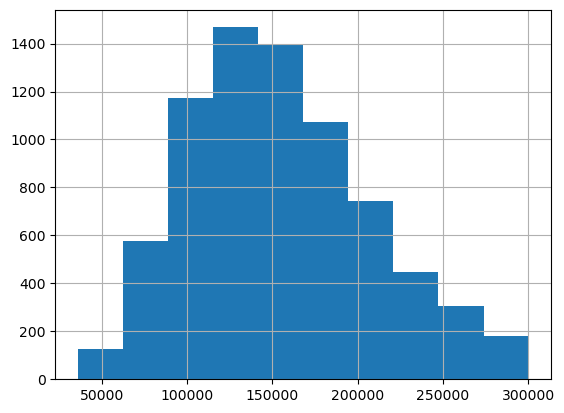

In [3]:
df.salary_in_usd.hist()


                    mean  count
work_year                      
2023       155800.978141   4712
2024       153182.779899   2776

                           mean  count
experience_level                      
MI                129373.530491   1853
SE                163201.500266   5635

                     mean  count
job_title                       
DAnalyst    117112.229485   1438
DEngineer   151616.862169   2416
DScientist  162493.881752   2351
MLE         189113.612627   1283

                       mean  count
remote_ratio                      
0.0           155607.414583   5239
1.0           153020.169409   2249

                       mean  count
company_size                      
L             164858.528302    106
M             154686.345435   7382


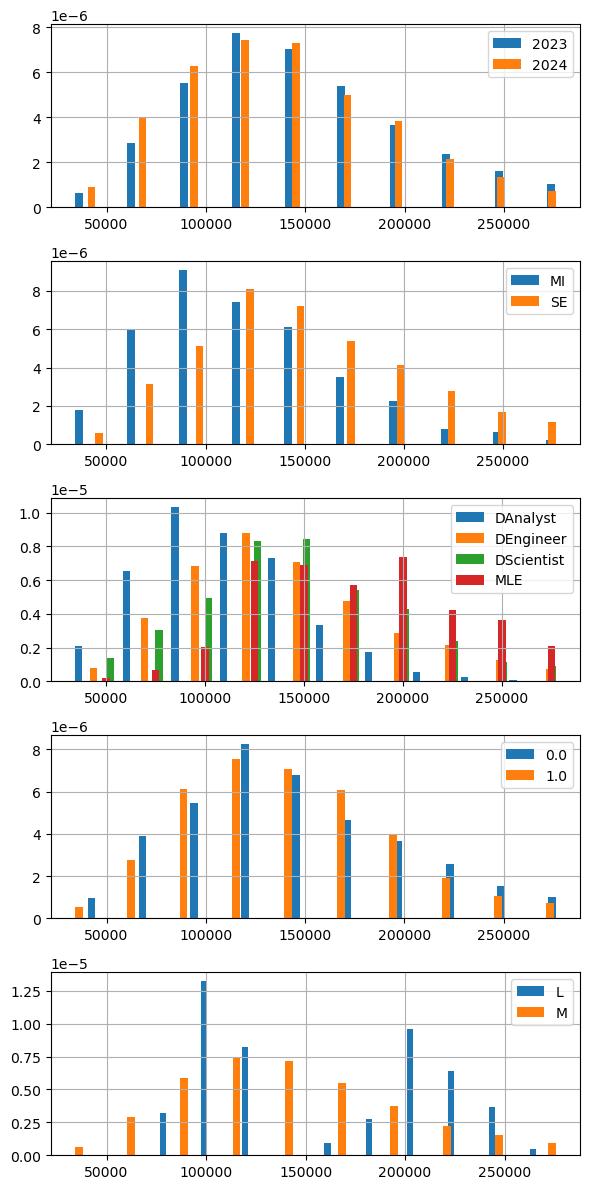

In [4]:
# See the histograms
def plot_histograms(df: pd.DataFrame):
    cols_to_plot = [c for c in list(df.columns) if c != 'salary_in_usd']
    fig, axs = plt.subplots(len(cols_to_plot), 1, tight_layout=True, figsize=(6,12))
    for index, c in enumerate(cols_to_plot):
        df.groupby([c])['salary_in_usd'].hist(legend=True, ax=axs[index], histtype='bar', rwidth=0.15, density=True, align='left')
        print(f"\n{df.groupby([c])['salary_in_usd'].agg(['mean', 'count'])}")

plot_histograms(df)

In [34]:
print(f"{df.groupby(['job_title','experience_level','company_size'])['salary_in_usd'].agg(['mean', 'count'])}")

                                                   mean  count
job_title  experience_level company_size                      
DAnalyst   MI               L              93000.000000      1
                            M             100504.808962    424
           SE               L             143042.857143      7
                            M             123955.315109   1006
DEngineer  MI               L             140625.333333     12
                            M             129367.647887    639
           SE               L             167459.375000     32
                            M             159604.274668   1733
DScientist MI               L             166408.333333     12
                            M             135904.015491    581
           SE               L             172986.363636     22
                            M             171232.881912   1736
MLE        MI               L             173577.777778      9
                            M             172281.994286

In [18]:
# To replace string values with numbers
def replace_str_with_values(df: pd.DataFrame):
    df_no_str = df.copy()
    columns_to_map = ['experience_level', 'job_title', 'company_size']
    for c in columns_to_map:
        unique_values = df_no_str[c].unique()
        mapping = {val: index for index, val in enumerate(unique_values)}
        print(mapping)
        df_no_str[c].replace(mapping, inplace=True)
    return df_no_str
    
df_no_str = replace_str_with_values(df)
df_no_str.head()

{'MI': 0, 'SE': 1}
{'DAnalyst': 0, 'MLE': 1, 'DScientist': 2, 'DEngineer': 3}
{'M': 0, 'L': 1}


,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size
0,2024,0,0,112300,0,0
1,2024,0,0,75100,0,0
2,2024,1,1,190000,0,0
3,2024,1,1,100000,0,0
4,2024,0,2,150650,0,0


In [4]:
# Source: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def encode_and_bind(df: pd.DataFrame, feature: list, drop_first = False) -> pd.DataFrame:
    dummies = pd.get_dummies(df[feature], drop_first=drop_first, prefix=feature, dtype=float)
    result = pd.concat([df, dummies], axis=1)
    result = result.drop([feature], axis=1)
    return result

df_ohe = df.copy()
features_to_encode = ['work_year', 'experience_level', 'job_title','company_size']
for f in features_to_encode:
    df_ohe = encode_and_bind(df_ohe, f, drop_first=True)

del f, features_to_encode

df_ohe.head()

,salary_in_usd,remote_ratio,work_year_2024,experience_level_SE,job_title_DEngineer,job_title_DScientist,job_title_MLE,company_size_M
0,112300,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,75100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,190000,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,100000,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,150650,0.0,1.0,0.0,0.0,1.0,0.0,1.0


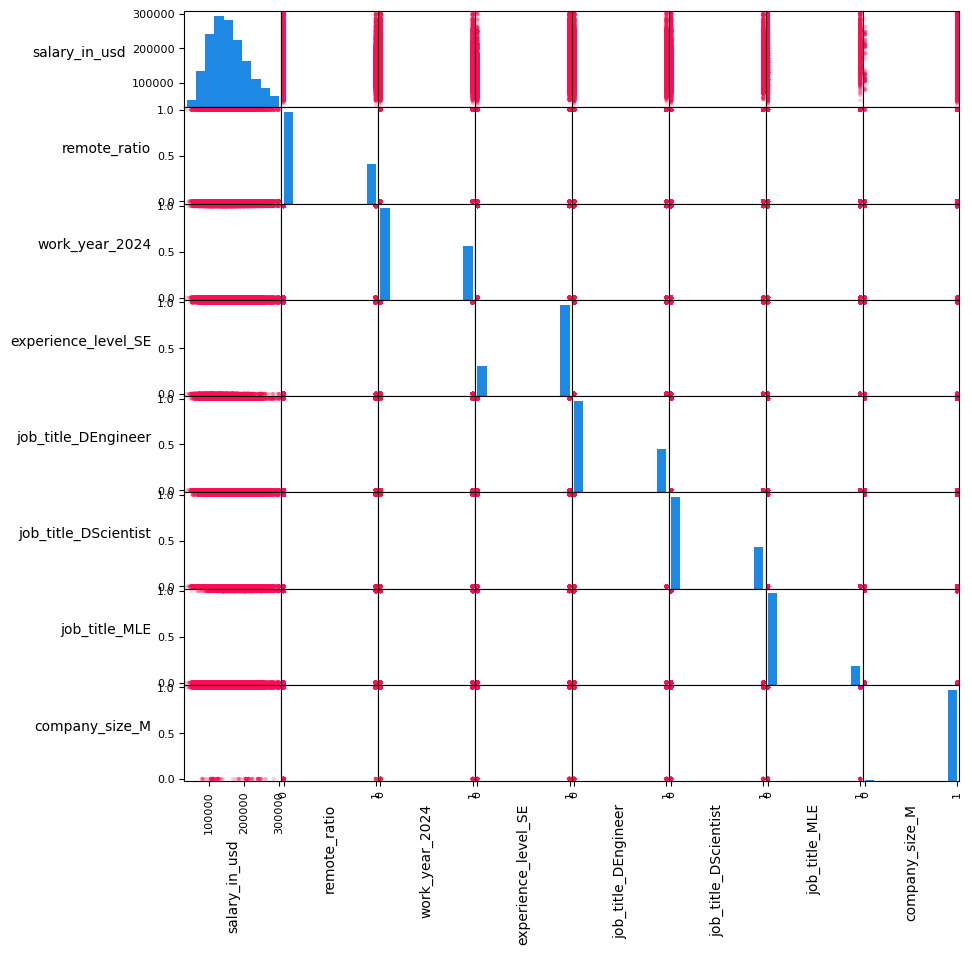

In [15]:
axes = pd.plotting.scatter_matrix(df_ohe, figsize=(10,10), alpha=0.2, c='#ff0d57', hist_kwds={'color':['#1E88E5']})
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

# First ML Model

In [16]:
def make_splits(df: pd.DataFrame, train_size=0.8, y_column = 'salary_in_usd'):
    assert 0 < train_size < 1
    y = df[y_column].to_numpy()
    X = df.drop(y_column, axis=1).to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, shuffle=True)
    return X_train, X_val, y_train, y_val
    
X_train, X_val, y_train, y_val = make_splits(df_ohe)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (5990, 7)
y_train shape: (5990,)
X_val shape: (1498, 7)
y_val shape: (1498,)


In [23]:
def get_rmse(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return round(np.sqrt(mean_squared_error(y_test, y_pred)), 0)  

def apply_linear_regression(X, y, regularizer=1):
    reg = Ridge(alpha=regularizer)
    reg.fit(X,y)
    print(f"R^2: {round(reg.score(X,y),2)}")
    print(f"rmse: {round(get_rmse(reg, X, y),0)}")
    print(f"Intercept: {np.round(reg.intercept_, 0)}")
    print(f"Coeficients: {np.round(reg.coef_, 0)}")
    return reg

model = apply_linear_regression(X_train, y_train, regularizer=50)
print(f"Val rmse: {get_rmse(model, X_val, y_val)}")
print(f"Weights per column:")
for index, c in enumerate(list(df_ohe.columns)[1:]):
    print(f"\t{c}: \t\t{np.round(model.coef_[index], 0)}")


del model, index, c    

R^2: 0.24
rmse: 46251.0
Intercept: 111589.0
Coeficients: [-1751.   333. 28191. 26502. 37280. 60271. -7798.]
Val rmse: 46929.0
Weights per column:
	remote_ratio: 		-1751.0
	work_year_2024: 		333.0
	experience_level_SE: 		28191.0
	job_title_DEngineer: 		26502.0
	job_title_DScientist: 		37280.0
	job_title_MLE: 		60271.0
	company_size_M: 		-7798.0


In [30]:
def apply_random_forest(X, y, regularizer=1):
    reg = RandomForestRegressor(random_state=0, max_depth=regularizer)
    reg.fit(X, y)
    print(f"R^2: {reg.score(X,y)}")
    print(f"rmse: {round(get_rmse(reg, X, y),0)}")
    return reg

model = apply_random_forest(X_train, y_train, regularizer=10)
print(f"Val rmse: {get_rmse(model, X_val, y_val)}")

print(f"Feature importances:")
for index, c in enumerate(list(df_ohe.columns)[1:]):
    print(f"\t{c}: \t\t{np.round(model.feature_importances_[index], 3)}")


del model, index, c

R^2: 0.2462936213764605
rmse: 45918.0
Val rmse: 47015.0
Feature importances:
	remote_ratio: 		0.017
	work_year_2024: 		0.018
	experience_level_SE: 		0.244
	job_title_DEngineer: 		0.185
	job_title_DScientist: 		0.153
	job_title_MLE: 		0.368
	company_size_M: 		0.016


# Build Causal Graph with Score-Method

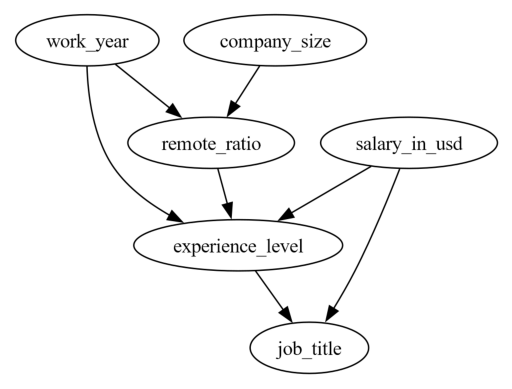

The score (local_score_BIC) of this learned graph is [[165175.94490299]]


In [19]:
def apply_ges(dataframe: pd.DataFrame, score_func = 'local_score_BIC'):
    # Run the method
    dataset = dataframe.to_numpy()
    Record = ges(dataset, score_func=score_func)
    pyd = GraphUtils.to_pydot(Record['G'], labels=list(dataframe.columns))
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    print(f"The score ({score_func}) of this learned graph is {Record['score']}")

apply_ges(df_no_str)

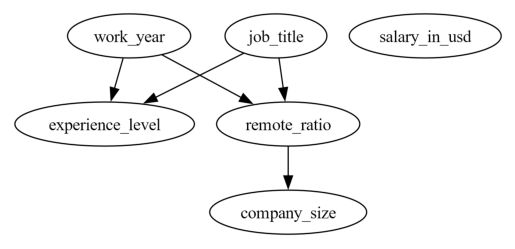

The score (local_score_BDeu) of this learned graph is 79973.96715110735


In [19]:
apply_ges(df_no_str, score_func='local_score_BDeu')

In [20]:
apply_ges(df_no_str, score_func='local_score_CV_general')

KeyboardInterrupt: 

In [14]:
apply_ges(df_no_str, score_func='local_score_marginal_general')

c:\Users\zente\anaconda3\envs\causal\lib\site-packages\causallearn\utils\ScoreUtils.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return evals.astype(float), evec.astype(float)
c:\Users\zente\anaconda3\envs\causal\lib\site-packages\causallearn\score\LocalScoreFunction.py:779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  covfunc = np.asarray(["covSum", ["covSEard", "covNoise"]])
c:\Users\zente\anaconda3\envs\causal\lib\site-packages\causallearn\utils\ScoreUtils.py:246: RuntimeWarning: invalid value encountered in sqrt
  x3 = x1 - d1 * (x2 - x1) ** 2 / (B + np.sqrt(B * B - A * d1 * (x2 - x1)))  # num. error possible, ok!


KeyboardInterrupt: 

In [15]:
apply_ges(df_no_str, score_func='local_score_CV_multi')

KeyboardInterrupt: 

In [16]:
apply_ges(df_no_str, score_func='local_score_marginal_multi')

c:\Users\zente\anaconda3\envs\causal\lib\site-packages\causallearn\score\LocalScoreFunction.py:890: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  covfunc = np.asarray(["covSum", ["covSEard", "covNoise"]])


KeyboardInterrupt: 

search stats:
{'n_parent_graphs_entries': 112, 'while_iter': 47, 'for_iter': 158, 'n_closed': 47, 'max_n_opened': 27}


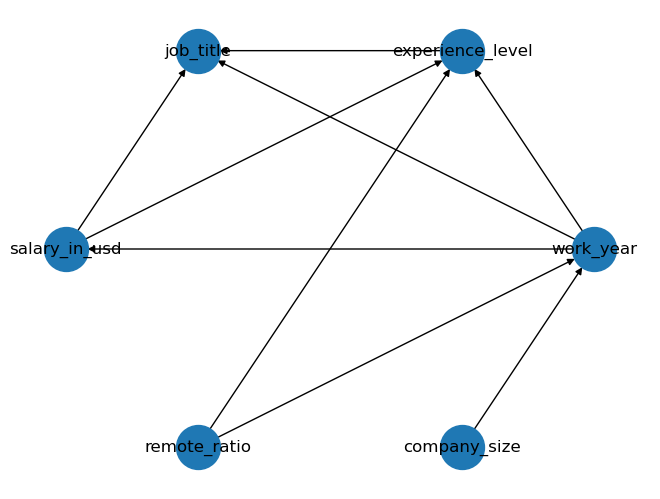

In [21]:
def apply_exact(dataframe: pd.DataFrame, search_method = 'astar'):
    dag_est, search_stats = bic_exact_search(dataframe.to_numpy(), search_method=search_method, verbose=True)
    print(f"search stats:\n{search_stats}")
    dag = nx.DiGraph(dag_est)
    nx.draw_circular(dag, with_labels=True, labels={i:c for i,c in enumerate(dataframe.columns)}, node_size=1000)    

apply_exact(df_no_str, search_method = 'astar')

search stats:
{'n_parent_graphs_entries': 112, 'n_order_graph_nodes': 64, 'n_order_graph_edges': 176}


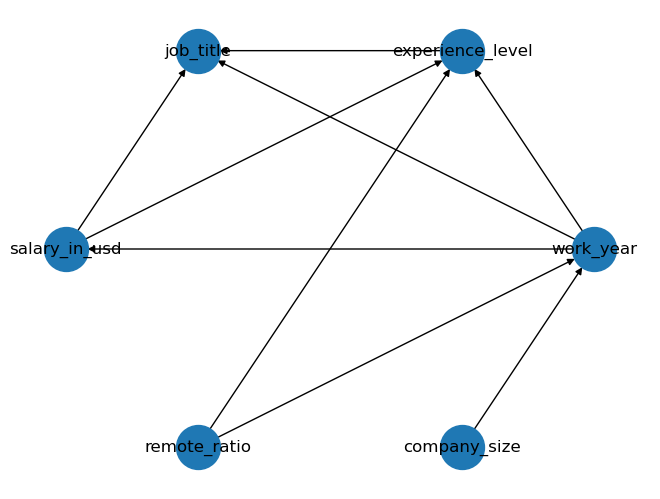

In [22]:
apply_exact(df_no_str, search_method = 'dp')

# LINGAM Methods

ADJ matrix:
[[    0.     0.     0. 28864. 33391. 43787. 67255.     0.]
 [    0.     0.    -5.     7.    -7.    -5.   -14.    21.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.    -0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.    -0.     0.]
 [    0.     0.     0.     0.    -1.     0.    -1.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.]]


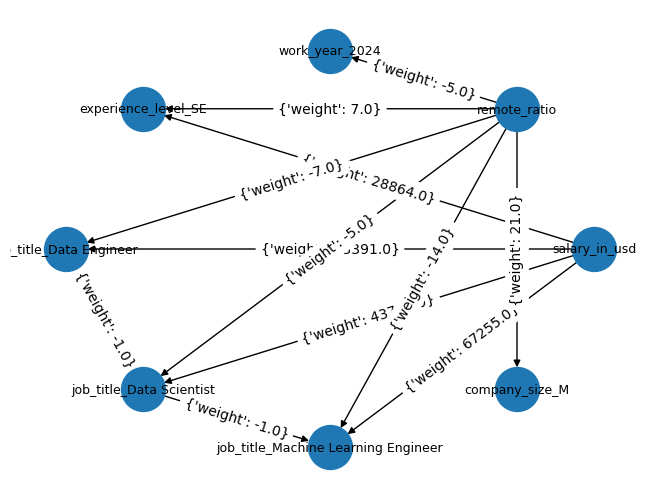

In [26]:
def run_lingam(df: pd.DataFrame):
        model = lingam.ICALiNGAM()
        model.fit(df.to_numpy())
        print(f"ADJ matrix:\n{np.round(model.adjacency_matrix_)}")
        dag = nx.DiGraph(np.round(model.adjacency_matrix_,0))
        nx.draw(dag,
                pos=nx.circular_layout(dag), 
                with_labels=True,
                labels={i:c for i,c in enumerate(df_ohe.columns)},
                node_size=1000,
                font_size=9
                )

        nx.draw_networkx_edge_labels(dag, pos=nx.circular_layout(dag))
run_lingam(df_ohe)

# DoWhy

Source: https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html

https://www.youtube.com/watch?v=ilpSZiDjdv0

In [ ]:
# (1) Model the problem
# (2) Use the model to identify the estimand -> an estimand is a way to estimate the desired quantity, its a strategy that will enable us to estimate the effect
# (3) Use the estimand and data to estimate the effect
# (4) Refute the estimate

In [5]:
df_ohe.head()

,salary_in_usd,remote_ratio,work_year_2024,experience_level_SE,job_title_DEngineer,job_title_DScientist,job_title_MLE,company_size_M
0,112300,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,75100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,190000,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,100000,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,150650,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [6]:
# Step 1: create causal graph
causal_graph = """digraph{
    salary_in_usd;
    remote_ratio;
    work_year_2024;
    experience_level_SE;
    job_title_DEngineer;
    job_title_DScientist;
    job_title_MLE;
    company_size_M;
    
    remote_ratio -> work_year_2024;
    experience_level_SE -> job_title_DEngineer;
    experience_level_SE -> job_title_DScientist;
    experience_level_SE -> job_title_MLE;
    
    remote_ratio -> salary_in_usd;
    work_year_2024 -> salary_in_usd;
    experience_level_SE -> salary_in_usd;
    job_title_DEngineer -> salary_in_usd;
    job_title_DScientist -> salary_in_usd;
    job_title_MLE -> salary_in_usd;
    company_size_M -> salary_in_usd;
}
"""

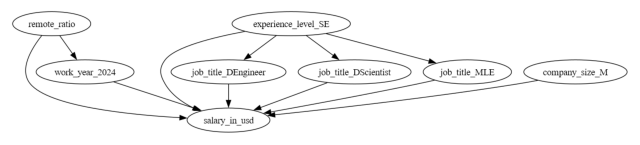

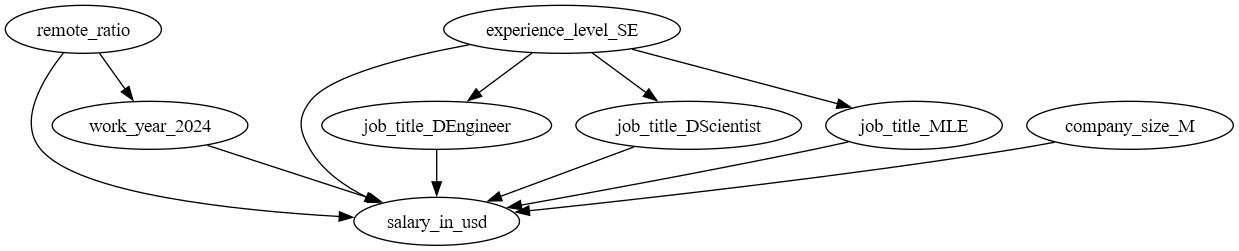

In [7]:
df_ohe.columns

Index(['salary_in_usd', 'remote_ratio', 'work_year_2024',
       'experience_level_SE', 'job_title_DEngineer', 'job_title_DScientist',
       'job_title_MLE', 'company_size_M'],
      dtype='object')

In [13]:
def apply_causal_model(data: pd.DataFrame, graph: str, treatment: str, outcome: str, use_front: bool = False):

    # (1) Set treatment and outcome
    model = dowhy.CausalModel(
            data = data,
            graph = graph,
            treatment = treatment,
            outcome = outcome)

    # (2): Identify estimand
    print("\nESTIMAND:")
    print("------------------------------------------------------------")
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print(identified_estimand)
    
    # (3): Estimate
    # Method_names
    # Propensity Score Matching:                                "backdoor.propensity_score_matching"
    # Propensity Score Stratification:                          "backdoor.propensity_score_stratification"
    # Propensity Score-based Inverse Weighting:                 "backdoor.propensity_score_weighting"
    # Linear Regression:                                        "backdoor.linear_regression"
    # Generalized Linear Models (e.g., logistic regression):    "backdoor.generalized_linear_model"
    # Instrumental Variables:                                   "iv.instrumental_variable"
    # Regression Discontinuity:                                 "iv.regression_discontinuity"
    # Two Stage Regression:                                     "frontdoor.two_stage_regression"
    estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",
                                 target_units="ate")
    print("\nESTIMATE BACKDOOR:")
    print("------------------------------------------------------------")
    print(estimate)
    
    if use_front:
        estimate = model.estimate_effect(identified_estimand, 
                                    method_name="frontdoor.two_stage_regression",
                                    target_units="ate")
        print("\nESTIMATE FRONTDOOR:")
        print("------------------------------------------------------------")
        print(estimate)
    
    
    # (4) Refutal
    print("\nREFUTAL:")
    print("------------------------------------------------------------")
    # Note that the causal part does not come from data. It comes from your assumptions that lead to identification. 
    # Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions 
    # were even correct in the first step or not!
    # What happens when another common cause exists? What happens when the treatment itself was placebo?

    # Method 1: Random Common Cause
    # Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. 
    # If our assumption was originally correct then the causal estimate shouldn’t change by much.
    refute1_results=model.refute_estimate(identified_estimand, 
                                        estimate,
                                        method_name="random_common_cause")
    print(refute1_results)

    # Method 2: Placebo Treatment Refuter
    # Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct 
    # then this newly found out estimate should go to 0.
    refute2_results=model.refute_estimate(identified_estimand,
                                        estimate,
                                        method_name="placebo_treatment_refuter")
    print(refute2_results)

    # Method 3: Data Subset Refuter
    # Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. 
    # If our assumptions were correct there shouldn’t be much variation.
    refute3_results=model.refute_estimate(identified_estimand, 
                                        estimate,
                                        method_name="data_subset_refuter")
    print(refute3_results)

    
    
apply_causal_model(data=df_ohe, graph=causal_graph.replace("\n", " "), treatment="experience_level_SE", outcome="salary_in_usd", use_front=False)


ESTIMAND:
------------------------------------------------------------
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                             
──────────────────────(E[salary_in_usd])
d[experience_level_SE]                  
Estimand assumption 1, Unconfoundedness: If U→{experience_level_SE} and U→salary_in_usd then P(salary_in_usd|experience_level_SE,,U) = P(salary_in_usd|experience_level_SE,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


ESTIMATE BACKDOOR:
------------------------------------------------------------
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                             
──────────────────────(E[salary_in_usd])
d[experience_level_SE]                  
Estimand assumption 1, Uncon

In [45]:
apply_causal_model(data=df_ohe, graph=causal_graph.replace("\n", " "), treatment="company_size_M", outcome="salary_in_usd")


ESTIMAND:
------------------------------------------------------------
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                          
─────────────────(E[salary_in_usd])
d[company_size_M]                  
Estimand assumption 1, Unconfoundedness: If U→{company_size_M} and U→salary_in_usd then P(salary_in_usd|company_size_M,,U) = P(salary_in_usd|company_size_M,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


ESTIMATE:
------------------------------------------------------------
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                          
─────────────────(E[salary_in_usd])
d[company_size_M]                  
Estimand assumption 1, Unconfoundedness: If U→{company_size_M} and U→salary_in_usd

In [46]:
apply_causal_model(data=df_ohe, graph=causal_graph.replace("\n", " "), treatment="remote_ratio", outcome="salary_in_usd")


ESTIMAND:
------------------------------------------------------------
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                         
──────────────(E[salary_in_usd])
d[remoteᵣₐₜᵢₒ]                  
Estimand assumption 1, Unconfoundedness: If U→{remote_ratio} and U→salary_in_usd then P(salary_in_usd|remote_ratio,,U) = P(salary_in_usd|remote_ratio,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


ESTIMATE:
------------------------------------------------------------
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                         
──────────────(E[salary_in_usd])
d[remoteᵣₐₜᵢₒ]                  
Estimand assumption 1, Unconfoundedness: If U→{remote_ratio} and U→salary_in_usd then P(salary_in_usd|remo

In [47]:
apply_causal_model(data=df_ohe, graph=causal_graph.replace("\n", " "), treatment="job_title_MLE", outcome="salary_in_usd")


ESTIMAND:
------------------------------------------------------------
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                              
────────────────(E[salary_in_usd|experience_level_SE])
d[job_title_MLE]                                      
Estimand assumption 1, Unconfoundedness: If U→{job_title_MLE} and U→salary_in_usd then P(salary_in_usd|job_title_MLE,experience_level_SE,U) = P(salary_in_usd|job_title_MLE,experience_level_SE)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


ESTIMATE:
------------------------------------------------------------
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                              
────────────────(E[salary_in_usd|experience

In [9]:
df_ohe.columns

Index(['salary_in_usd', 'remote_ratio', 'work_year_2024',
       'experience_level_SE', 'job_title_DEngineer', 'job_title_DScientist',
       'job_title_MLE', 'company_size_M'],
      dtype='object')

In [10]:
apply_causal_model(data=df_ohe, graph=causal_graph.replace("\n", " "), treatment="job_title_DScientist", outcome="salary_in_usd")


ESTIMAND:
------------------------------------------------------------
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                 
───────────────────────(E[salary_in_usd|experience_level_SE])
d[job_title_DScientist]                                      
Estimand assumption 1, Unconfoundedness: If U→{job_title_DScientist} and U→salary_in_usd then P(salary_in_usd|job_title_DScientist,experience_level_SE,U) = P(salary_in_usd|job_title_DScientist,experience_level_SE)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


ESTIMATE:
------------------------------------------------------------
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                            

In [11]:
apply_causal_model(data=df_ohe, graph=causal_graph.replace("\n", " "), treatment="job_title_DEngineer", outcome="salary_in_usd")


ESTIMAND:
------------------------------------------------------------
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                 
──────────────────────(E[salary_in_usd|experience_level_SE])
d[job_title_DEngineer]                                      
Estimand assumption 1, Unconfoundedness: If U→{job_title_DEngineer} and U→salary_in_usd then P(salary_in_usd|job_title_DEngineer,experience_level_SE,U) = P(salary_in_usd|job_title_DEngineer,experience_level_SE)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


ESTIMATE:
------------------------------------------------------------
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                 
─

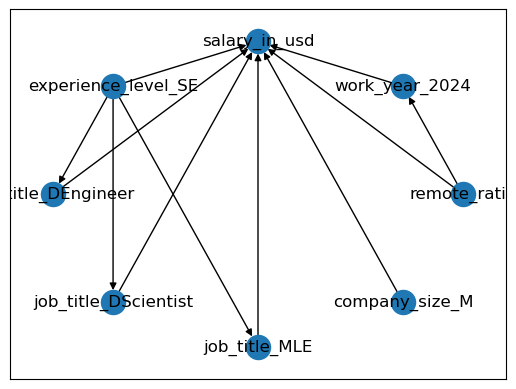

In [43]:
causal_graph = nx.DiGraph(
    [
        ('remote_ratio', 'work_year_2024'),
        ('remote_ratio', 'salary_in_usd'),
        ('work_year_2024', 'salary_in_usd'),
        ('experience_level_SE', 'job_title_DEngineer'),
        ('experience_level_SE', 'job_title_DScientist'),
        ('experience_level_SE', 'job_title_MLE'),
        ('experience_level_SE', 'salary_in_usd'),
        ('job_title_DEngineer', 'salary_in_usd'),
        ('job_title_DScientist', 'salary_in_usd'),
        ('job_title_MLE', 'salary_in_usd'),
        ('company_size_M', 'salary_in_usd')
    ])

pos = nx.circular_layout(causal_graph)
nx.draw_networkx_nodes(causal_graph, pos=pos)
nx.draw_networkx_labels(causal_graph, pos=pos)
nx.draw_networkx_edges(causal_graph, pos)

In [44]:
causal_model = gcm.StructuralCausalModel(causal_graph)

# Assign causal mechanism
gcm.auto.assign_causal_mechanisms(causal_model, df_ohe)

In [45]:
# Fit a model
gcm.fit(causal_model, df_ohe)

Fitting causal mechanism of node company_size_M: 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]      


In [46]:
# Quantiy Arrow Strength
# By quantifying the strength of an arrow, we answer the question: 
# How strong is the causal influence from a cause to its direct effect?
def mean_diff(Y_old, Y_new): 
    return np.mean(Y_new) - np.mean(Y_old)

gcm.arrow_strength(causal_model, 'salary_in_usd', difference_estimation_func=mean_diff, n_jobs=-1)

{('company_size_M', 'salary_in_usd'): -166.18390789473673,
 ('experience_level_SE', 'salary_in_usd'): -514.4753183881955,
 ('job_title_DEngineer', 'salary_in_usd'): 82.22755535714282,
 ('job_title_DScientist', 'salary_in_usd'): 39.27108646616469,
 ('job_title_MLE', 'salary_in_usd'): -239.5402329192546,
 ('remote_ratio', 'salary_in_usd'): -116.38486434108563,
 ('work_year_2024', 'salary_in_usd'): -86.17268661971816}

In [54]:
# Estimating Average Causal Effect
gcm.average_causal_effect(causal_model,
                         'salary_in_usd',
                         interventions_alternative={'experience_level_SE': lambda x: 1},
                         interventions_reference={'experience_level_SE': lambda x: 0},
                         observed_data=df_ohe)

In [ ]:
# Estimating Average Causal Effect
gcm.average_causal_effect(causal_model,
                         'salary_in_usd',
                         interventions_alternative={'experience_level_SE': lambda x: 1},
                         interventions_reference={'experience_level_SE': lambda x: 0},
                         observed_data=df_ohe)